In [11]:
import numpy as np
import pandas as pd
from numpy import linalg as LA
from sklearn.decomposition import PCA
import random

csv = pd.read_csv("yelp_2k.csv")

In [12]:
data = [d.lower() for d in csv.text]
label = csv.stars

In [13]:
# Configuration 
_min_df = 3;
_max_df = 1250;
_stop_words = ['would', 'out', 'when', 'all', 'if', 'he', 'as', 'there', 'food', 
               'place', 'be', 'are', 'were', 'so', 'at', 'me', 'had', 'but', 'have', 'not', 
               'on', 'with', 'you', 'we', 'this', 'they', 'that', 'is', 'my', 'in', 'for', 'of', 
               'it', 'was', 'to', 'and', 'the', 'you', '2am', '2x', '33', '37', '38', '3am', '43', 
               '48', '4oz', '4x', '51', '55', '600', '6pm', '700', '7am', '7pm', '89']

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
# vectorizer = CountVectorizer(min_df = _min_df, max_df = _max_df)
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data)
wordCount = np.sum(np.array(X.toarray()), axis = 0)
RankWords = [x for _,x in sorted(zip(wordCount,vectorizer.get_feature_names()))]

plt.scatter(np.arange(len(wordCount)), sorted(wordCount), label = 'counts')
plt.title("Word Frequency without stop_word and bounding")
plt.xlabel("Word Rank")
plt.ylabel("Word Count")
plt.legend(loc='best')
plt.show()

<Figure size 640x480 with 1 Axes>

In [15]:
RankWordsPair = [(y,x) for (y,x) in sorted(zip(wordCount,vectorizer.get_feature_names()))]


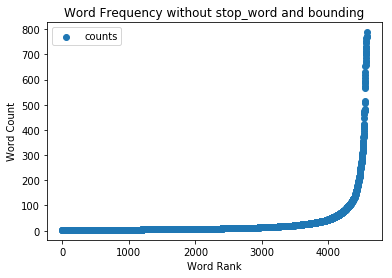

In [16]:
new_vectorizer = CountVectorizer(min_df = _min_df, max_df = _max_df, stop_words = _stop_words)
X = new_vectorizer.fit_transform(["horrible customer service"] + data)
wordCount = np.sum(np.array(X.toarray()), axis = 0)

plt.scatter(np.arange(len(wordCount)), sorted(wordCount), label = 'counts')
plt.title("Word Frequency without stop_word and bounding")
plt.xlabel("Word Rank")
plt.ylabel("Word Count")
plt.legend(loc='best')
plt.show()

bag_vec = X.toarray()

In [17]:
from sklearn.metrics.pairwise import cosine_distances
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(metric = "cosine")
neigh.fit(bag_vec[1:])
result = neigh.kneighbors([bag_vec[0]], 5)
print(result[0])
for i in result[1][0]:
    print("Reviews", i)
    print(data[i])
    print("\n")

[[0.35450278 0.49871959 0.55555556 0.61509982 0.61764044]]
Reviews 1808
rogers ...

1) is over priced
2) have horrible customer service
3) faulty and incorrect billing
4) poor customer service
5) not enough options
6) never arrive for an appointment


Reviews 90
horrible service, horrible customer service, and horrible quality of service!  do not waste your time or money using this company for your pool needs.  dan (602)363-8267 broke my pool filtration system and left it in a nonworking condition.  he will not repair the issue he caused, and told me to go somewhere else.  

save yourself the hassle, there are plenty of other quality pool companies out there.  

take care!


Reviews 729
service was horrible came with a major attitude. payed 30 for lasagna and was no where worth it. won't ever be going back and will never recommend this place. was treated absolutely horrible. horrible.


Reviews 825
customer service was super bad. the pizza was cold by the time they delivered it to me.


[[0.35450278 0.49871959 0.55555556 ... 1.         1.         1.        ]]


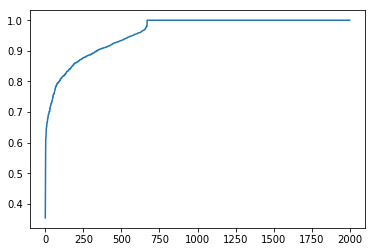

In [26]:
result = neigh.kneighbors([bag_vec[0]], 2000)
print(result[0])
# for i in result[1][0]:
#     print("Reviews", i)
#     print(data[i])
#     print("\n")
plt.plot(result[0][0])
plt.show()

In [27]:
from sklearn.linear_model import LogisticRegression
train_data = bag_vec[1:][0:1800]
train_label = np.array(label[0:1800])
test_data = bag_vec[1:][1800:]
test_label = np.array(label[1800:])
lr = LogisticRegression(solver="liblinear").fit(train_data, train_label)
predict_label = lr.predict(test_data)
x = 0
for i in range(200):
    if(predict_label[i] == test_label[i]):
        x+=1
print(x/200)

0.925


In [28]:
predicted = lr.predict_proba(bag_vec[1:])
pos, neg = [], []
for i in range(0,2000):
    if(label[i] == 5):
        pos.append(predicted[i][1])
    else:
        neg.append(predicted[i][1])

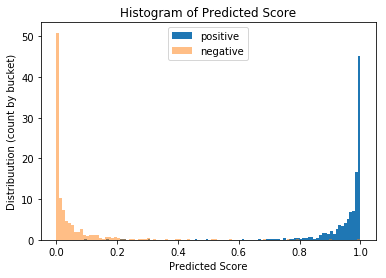

In [11]:
plt.hist(pos, bins=100, density=True, label = 'positive')
plt.hist(neg, bins=100, density=True, alpha=0.5, label = 'negative')
plt.title("Histogram of Predicted Score")
plt.xlabel("Predicted Score")
plt.ylabel("Distribuution (count by bucket)")
plt.gca().legend(('y0','y1'))
plt.legend(loc=9)
plt.show()

In [12]:
min = 10000;
new_threshold = -1;
for iter in range(0, 100):
    threshold = iter/100
    invalid_x = 0;
    invalid_y = 0;
    for i in pos:
        if(i < threshold):
            invalid_x += 1
    for i in neg:
        if(i > threshold):
            invalid_y += 1
    if(invalid_x + invalid_y < min):
        min = invalid_x + invalid_y
        new_threshold = iter/100
print(new_threshold)

0.58


In [29]:
predicted = lr.predict_proba(test_data)
correct = 0
for i in range(0,200):
    if(predicted[i][0] > 0.54):
        if(test_label[i] == 1):
            correct += 1
    else:
        if(test_label[i] == 5):
            correct += 1
print(correct/200)

0.935


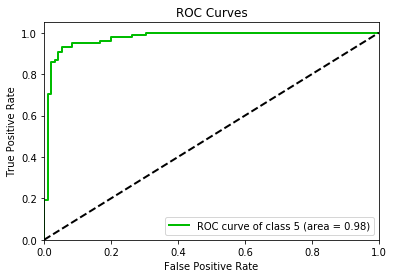

In [14]:
import scikitplot as skplt
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

skplt.metrics.plot_roc(test_label, lr.predict_proba(test_data), plot_micro=False, 
                       plot_macro=False, classes_to_plot = [5])
plt.show()

In [32]:
fpr, tpr, threshold = metrics.roc_curve(test_label, [x[1] for x in lr.predict_proba(test_data)], pos_label=5)

max = -1
new_threshold = -1
for i in range(len(fpr)):
    if(tpr[i] - fpr[i]) > max :
        new_threshold = threshold[i]
print(new_threshold)

1.3640350352187472e-12
